In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from anndata import AnnData
sc.settings.verbosity = 3
from scipy.sparse import csc_matrix
from anndata import AnnData
import gseapy as gp

from tqdm import tqdm
import os 
import importlib
import sys
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

from scipy.sparse import save_npz, load_npz
def get_min_distance(adata):
    locations = adata.obsm['spatial'].copy()
    distances = np.linalg.norm(locations[:, np.newaxis] - locations, axis=2)
    np.fill_diagonal(distances, np.inf)
    min_distances = np.min(distances, axis=1)
    average_min_distance = np.mean(min_distances)
    return average_min_distance

def _normalize_data(X, counts, after= None):
    from sklearn.utils.sparsefuncs import inplace_row_scale
    X = X.copy()
    after = np.median(counts_greater_than_zero, axis=0) if after is None else after
    counts += counts == 0
    counts = counts / after
    inplace_row_scale(X, 1 / counts)
    return X

In [2]:
import gseapy as gp

In [3]:
sample = 'CRC-P19-T'

In [4]:
rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')

In [ ]:
###
## Due to the random process involved in graph construction, 
## the names and order of SNV (Single Nucleotide Variant) groups may vary with each clustering iteration. 
## However, the total number of groups remains consistent across different runs. 
## This variability in naming and ordering does not affect the overall results or the integrity of the clustering analysis.
###

In [5]:
snv_df = snv.to_df().T
window_size = 100000
snv_df['chrom'] = snv_df.index.map(lambda x: x.split('_')[0])
snv_df['num'] = snv_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv_df['windows'] = snv_df['chrom'] +'@'+ snv_df['num']
del snv_df['chrom']
del snv_df['num']
snv_df = snv_df.groupby('windows').sum().T
snv_gene_adata = AnnData(snv_df)
snv_gene_adata.X = csc_matrix(snv_gene_adata.X)
snv_gene_adata.obsm['spatial'] = snv.obsm['spatial']

In [6]:
snv_gene_adata.obs['cluster'] = rna.obs['cluster']
snv_gene_adata = snv_gene_adata[snv_gene_adata.obs['cluster']!='Normal'].copy()
sc.pp.filter_genes(snv_gene_adata,min_cells=1)

filtered out 1 genes that are detected in less than 1 cells


In [33]:
snv_gene_adata.obs['umi'] = rna.obs['total_counts']

In [34]:
norm_snv_gene_adata = snv_gene_adata.copy()
norm_snv_gene_adata.X = np.log1p(_normalize_data(norm_snv_gene_adata.X,norm_snv_gene_adata.obs['umi'].values,after = 1e4))

In [9]:
radius = get_min_distance(snv_gene_adata)
ss_con = ss.build_connect(snv_gene_adata, radius = 5 * (radius), include_self=False, norm=True, scaling=False, rank2=False,
                          rank_cutoff = 50, n_neighbors = 30, use_raw=False, decay='Gaussian')

/storage/liuyi/00.SNP_project/jupyter/bin/spatialSNV_r.py:88: RuntimeWarning: divide by zero encountered in divide
  scalers = 1 / scalers


Step1: cell-cell connectivity calculation finished, Fri Aug  2 23:46:09 2024
Step2: ranking SNV expression values finished, Fri Aug  2 23:46:28 2024


/storage/liuyi/00.SNP_project/jupyter/bin/spatialSNV_r.py:152: RuntimeWarning: divide by zero encountered in divide
  scaler_mode = 1/mode


Step3: cell-SNV connectivity calculation finished, Fri Aug  2 23:46:30 2024
Step5: SNV-SNV connectivity calculation finished, Fri Aug  2 23:46:40 2024


In [10]:
snv_gene_adata,ac = ss.build_sg(snv_gene_adata, con = ss_con,resolution = 10, syn = False)

In [11]:
import squidpy as sq
def cal_moran(adata, n_jobs=1, use_raw=False, genes=None, **kwds):
    sq.gr.spatial_neighbors(adata, coord_type='grid')    
    if genes is None:
        genes = list(adata.var_names)
    sq.gr.spatial_autocorr(adata, n_jobs=n_jobs, mode='moran', use_raw=use_raw, genes=genes, **kwds)

In [12]:
cal_moran(ac)

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `None` permutations using `1` core(s)
Adding `adata.uns['moranI']`
Finish (0:00:00)


In [13]:
morandf = ac.uns['moranI']

In [14]:
morandf['I'].index

Index(['sg0', 'sg44', 'sg30', 'sg10', 'sg2', 'sg18', 'sg12', 'sg188', 'sg31',
       'sg22',
       ...
       'sg362', 'sg667', 'sg447', 'sg414', 'sg356', 'sg337', 'sg328', 'sg510',
       'sg575', 'sg459'],
      dtype='object', length=701)

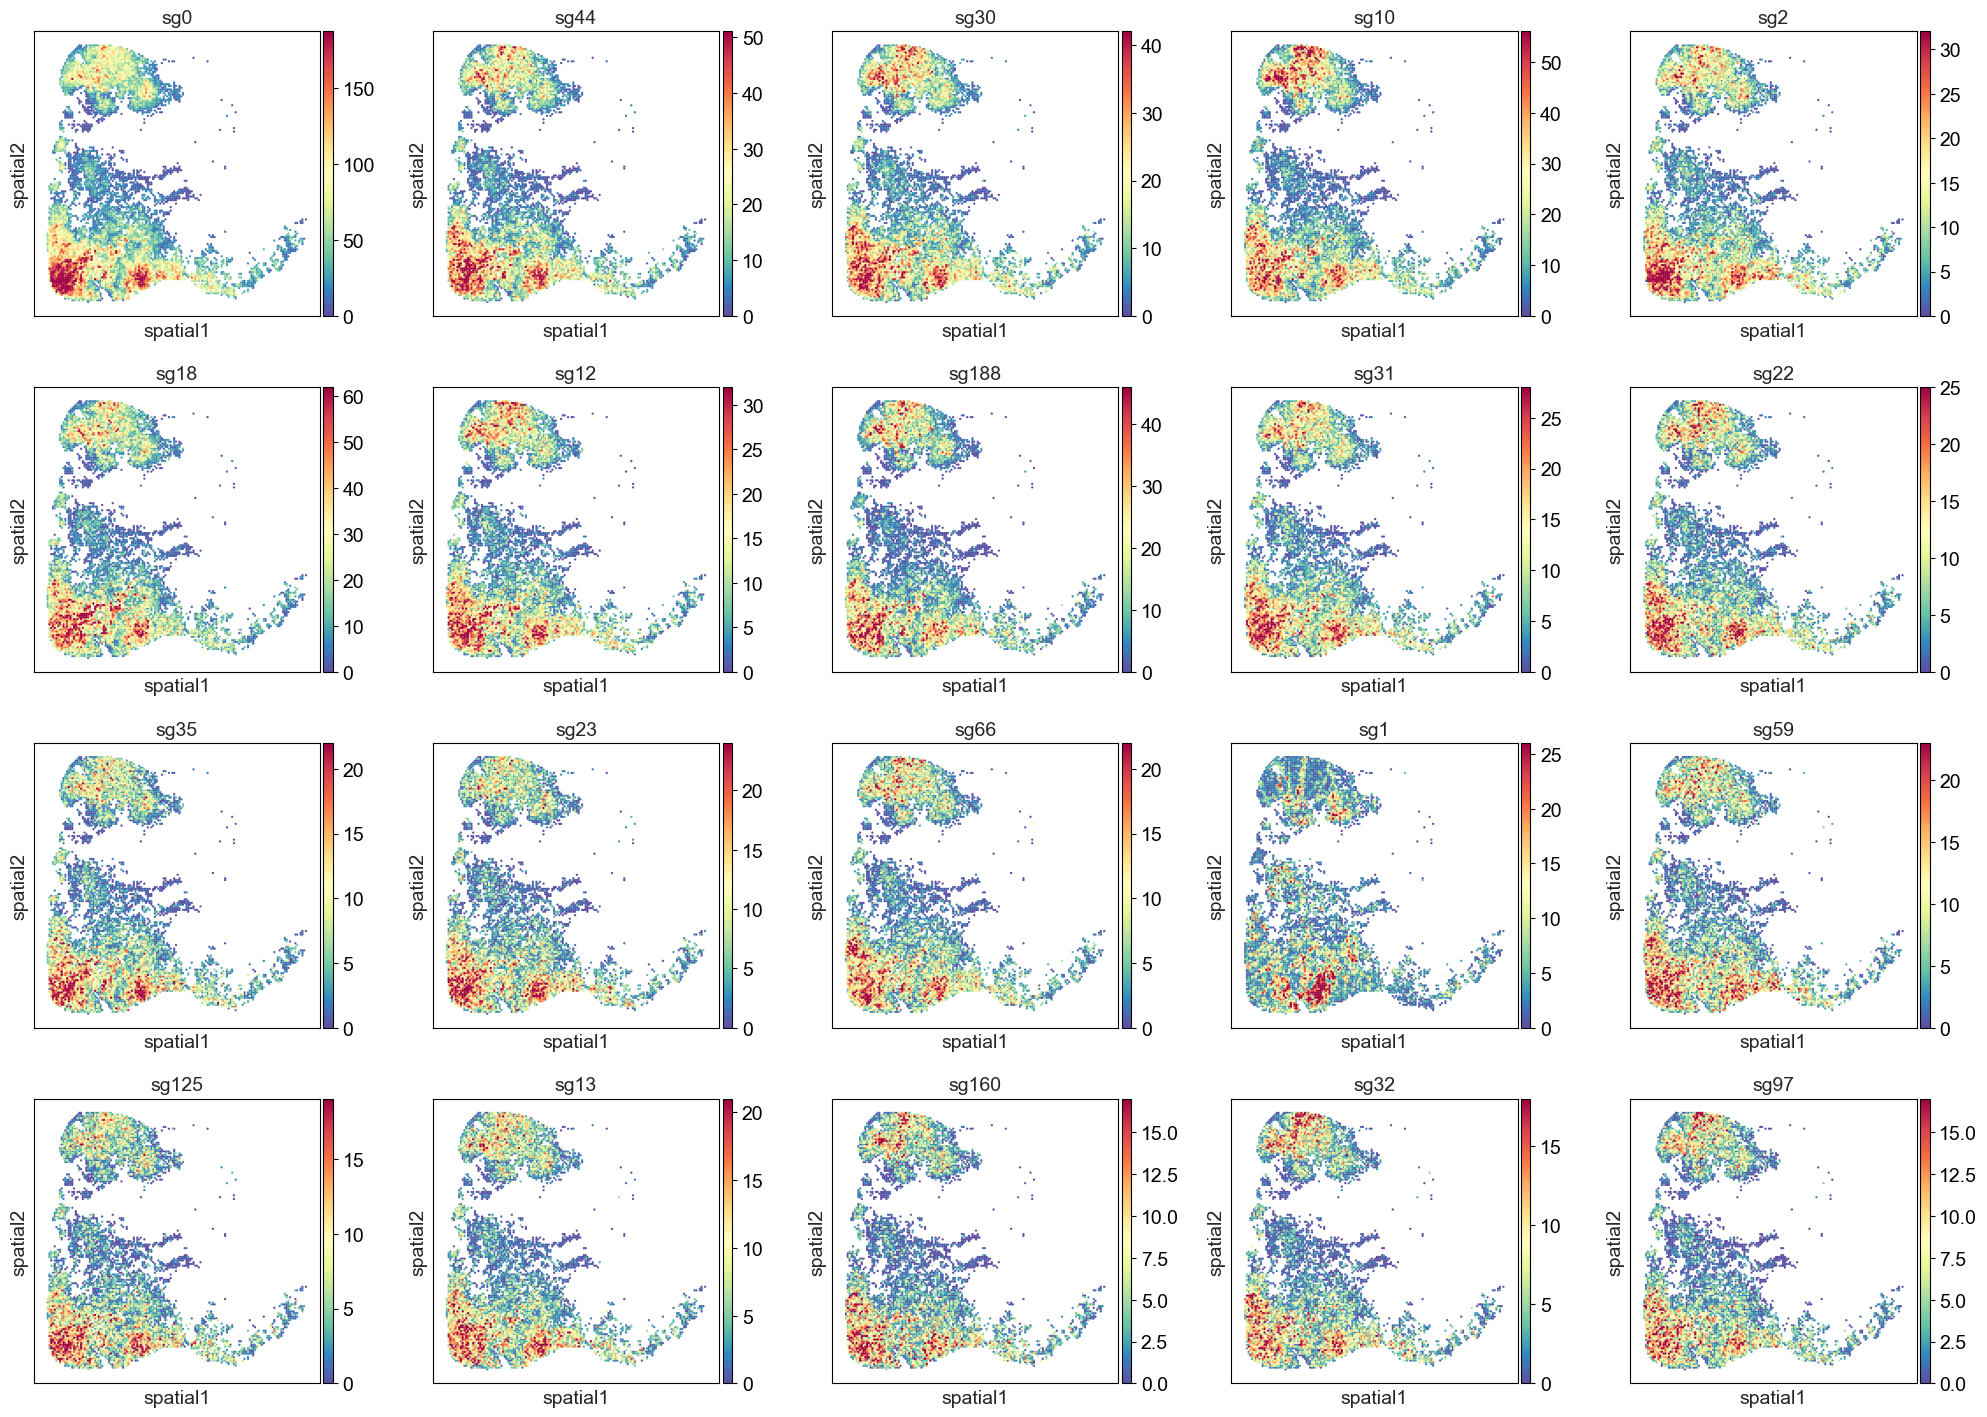

In [15]:
sc.pl.spatial(ac,basis = 'spatial',color = morandf['I'].index[:20],spot_size = 130,cmap = 'Spectral_r',vmax = 'p98',ncols = 5)

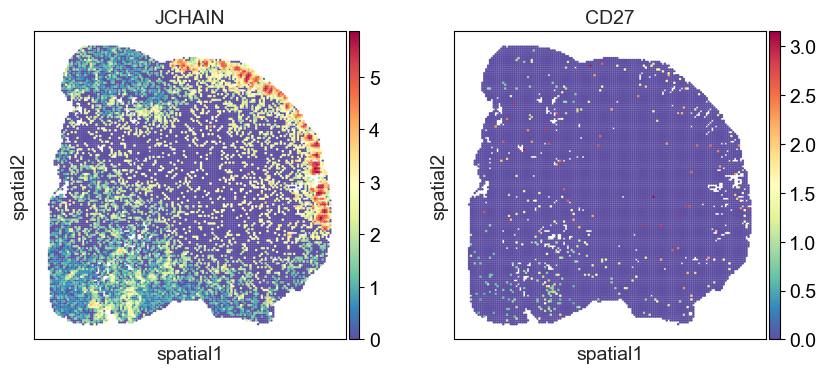

In [71]:
sc.pl.spatial(rna,basis = 'spatial',color = ['JCHAIN','CD27'],spot_size = 130,cmap = 'Spectral_r',ncols = 5,save='plasma.pdf')

In [16]:
tmp_df = snv.var.copy()
tmp_df['chrom'] = tmp_df.index.map(lambda x: x.split('_')[0])
tmp_df['num'] = tmp_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv.var['windows'] = tmp_df['chrom'] +'@'+ tmp_df['num']

In [17]:
import gseapy as gp
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 1].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()
geneList.to_csv('sg1.gene.tsv',header=None,sep = '\t')


In [61]:
geneList.index.to_frame()['gene_name'].to_csv('sg1.go.tsv',index=None,header=None)

In [18]:
pre_res = gp.prerank(rnk= "./sg1.gene.tsv",gene_sets= "/storage/liuyi/data/gmt/h.all.v2023.1.Hs.symbols.gmt",threads=1,min_size=5,max_size=1000,permutation_num=1000, outdir=None, seed=6,verbose=True,)

2024-08-02 23:47:55,237 [WARNING] Duplicated values found in preranked stats: 92.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-08-02 23:47:55,238 [INFO] Parsing data files for GSEA.............................
2024-08-02 23:47:55,247 [INFO] 0041 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-08-02 23:47:55,248 [INFO] 0009 gene_sets used for further statistical testing.....
2024-08-02 23:47:55,249 [INFO] Start to run GSEA...Might take a while..................
2024-08-02 23:47:55,347 [INFO] Congratulations. GSEApy runs successfully................



In [19]:
pre_res.res2d

Name                                        Term        ES       NES  \
0  prerank  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.756385  1.879678   
1  prerank                        HALLMARK_COAGULATION  0.757433  1.682941   
2  prerank                          HALLMARK_APOPTOSIS   0.85443  1.642483   
3  prerank                         HALLMARK_MYOGENESIS  0.791001  1.629419   
4  prerank                       HALLMARK_ANGIOGENESIS  0.792453  1.496391   
5  prerank                         HALLMARK_COMPLEMENT  0.698997  1.435456   
6  prerank                     HALLMARK_UV_RESPONSE_DN  0.628139  1.330715   
7  prerank                         HALLMARK_GLYCOLYSIS  0.673146  1.305798   
8  prerank                            HALLMARK_HYPOXIA  0.671824  1.277754   

  NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0       0.0       0.0        0.0  24/33  28.05%   
1  0.002128   0.00672      0.011   9/12  21.95%   
2       0.0  0.006346      0.016    6/6  17.68%   
3  0.004405    0.0056      0.019    4/8   9.76%   
4  0.024631  0.038527      0.144    5/5  23.17%   
5  0.043527  0.060105      0.248    6/8  21.95%   
6  0.104255  0.130395      0.497   7/10  32.93%   
7  0.129825  0.134255      0.561    5/6  31.10%   
8  0.138756  0.145097      0.636    5/6  31.10%   

                                          Lead_genes  
0  COL6A3;TIMP3;COL3A1;SPARC;HTRA1;COL1A2;COL5A1;...  
1  TIMP3;SPARC;C1R;HTRA1;MMP2;GNB2;SERPING1;C1S;C...  
2                       TIMP3;TIMP2;MMP2;DCN;BGN;LUM  
3                         COL6A3;COL3A1;SPARC;COL6A2  
4                       COL3A1;COL5A2;VCAN;LUM;POSTN  
5                  TIMP2;C1R;GNB2;SERPING1;C1S;CSRP1  
6       COL3A1;COL1A2;COL5A2;PMP22;SDC2;FBLN5;COL1A1  
7                         COL5A1;DCN;VCAN;SDC2;CXCR4  
8                          COL5A1;DCN;BGN;SDC2;CXCR4

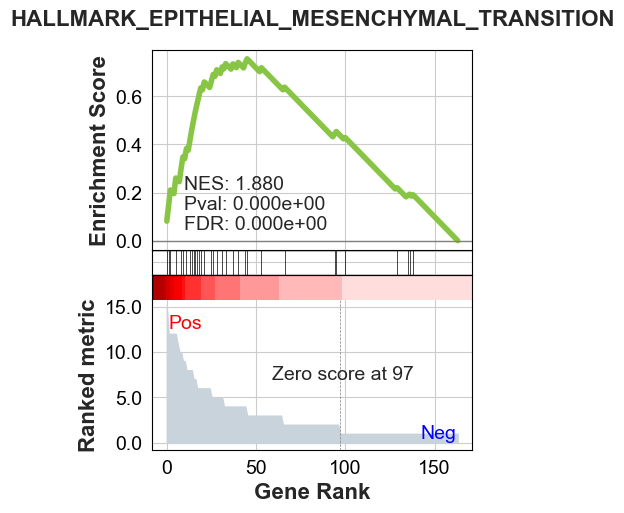

In [54]:
term = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
axs = pre_res.plot(terms= term, show_ranking=True) # v1.0.5
axs.savefig('./SupFigure/gsea.pdf',bbox_inches = 'tight')

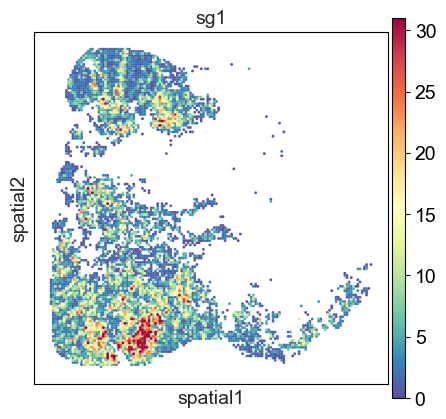

In [56]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(ac,color = ['sg1'],spot_size = 130,vmax = 'p99',cmap = 'Spectral_r',ax = ax)
fig.savefig('./SupFigure/sg1.pdf')

In [23]:
procon = ss.mul_rank_weight(ss_con, rank_cutoff=50, ret='value',transpose=False, include_self=False, nthreads=20)
procon = ss.weight_norm(procon, alpha=1)

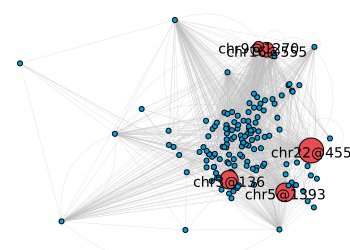

In [63]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 1].var_names
indices = [np.where(snv_gene_adata.var_names == gene)[0][0] for gene in inlist if gene in snv_gene_adata.var_names]
sub_con = procon[indices, :][:, indices]
g = ss.create_graph(sub_con, directed=True)
g.vs['name'] = inlist
visual_style = {}
visual_style["bbox"] = (300, 300) 
visual_style["margin"] = 20
visual_style["edge_color"] = "gray"
import igraph as ig
topn = 5
degrees = g.degree()
n = len(g.vs)
top_indices = sorted(range(n), key=lambda i: degrees[i], reverse=True)[:topn]
top_degrees = [degrees[i] for i in top_indices]
max_degree_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:topn]
labels = ["" for _ in range(len(g.vs))]
for idx in max_degree_indices:
    labels[idx] = g.vs[idx]["name"]
    
min_top_degree, max_top_degree = min(top_degrees), max(top_degrees)
node_sizes = [5] * n 
for idx in top_indices:
    if max_top_degree > min_top_degree: 
        size = ((degrees[idx] - min_top_degree) / (max_top_degree - min_top_degree) * 15) + 10  
    else:
        size = 25
    node_sizes[idx] = max(size, 5)
    
layout = g.layout("mds")   #"grid"  "graphopt" "davidson_harel"  "drl" "mds" "kk"
visual_style = {}
visual_style["bbox"] = (350, 250)
visual_style["edge_color"] = "gray"
visual_style['edge_arrow_size'] = 0.1  # 调整箭头大小
ig.plot(g, layout=layout,
        vertex_size=node_sizes,edge_width = 0.2,
        vertex_color=['#E84B50' if idx in top_indices else '#00A1DF' for idx in range(n)],
        vertex_label=labels,target='./SupFigure/sg1.crc19.pdf',
        **visual_style)

In [ ]:
#  sg2

In [42]:
total_gene = []
for win in ['chr22@455','chr5@1393','chr3@136','chr9@1270','chr16@555']:
    node_index = g.vs.find(name=win).index
    neighbors = g.neighbors(node_index, mode='out')
    neighbors = g.vs[neighbors]['name']
    for i in neighbors:
        total_gene.extend(snv[:,snv.var['windows'] == i].var['gene_name'].drop_duplicates().values)

In [50]:
snv[:,snv.var['windows'] == 'chr16@555'].var

gene_ids    feature_types  SNVDepth  SNVCount  \
chr16_55506163:G>C  chr16_55506163:G>C  Gene Expression     166.0     158.0   
chr16_55506164:C>A  chr16_55506164:C>A  Gene Expression     135.0     129.0   
chr16_55505898:C>T  chr16_55505898:C>T  Gene Expression     100.0      91.0   
chr16_55506164:C>G  chr16_55506164:C>G  Gene Expression     165.0     160.0   
chr16_55505898:C>A  chr16_55505898:C>A  Gene Expression     113.0     100.0   
chr16_55506164:C>T  chr16_55506164:C>T  Gene Expression      95.0      94.0   
chr16_55506223:G>A  chr16_55506223:G>A  Gene Expression      81.0      81.0   
chr16_55585302:G>A  chr16_55585302:G>A  Gene Expression      29.0      26.0   
chr16_55586634:A>G  chr16_55586634:A>G  Gene Expression     118.0     106.0   
chr16_55505972:C>T  chr16_55505972:C>T  Gene Expression     128.0     119.0   

                    n_cells  Func ExonicFunc gene_name gene_lenth Func_L0  \
chr16_55506163:G>C      154  UTR3          .      MMP2     116991     UTR   
chr16_55506164:C>A      127  UTR3          .      MMP2     116991     UTR   
chr16_55505898:C>T       87  UTR3          .      MMP2     116991     UTR   
chr16_55506164:C>G      153  UTR3          .      MMP2     116991     UTR   
chr16_55505898:C>A       98  UTR3          .      MMP2     116991     UTR   
chr16_55506164:C>T       93  UTR3          .      MMP2     116991     UTR   
chr16_55506223:G>A       79  UTR3          .      MMP2     116991     UTR   
chr16_55585302:G>A       26  UTR3          .    LPCAT2      77594     UTR   
chr16_55586634:A>G      105  UTR3          .    LPCAT2      77594     UTR   
chr16_55505972:C>T      117  UTR3          .      MMP2     116991     UTR   

                      windows  
chr16_55506163:G>C  chr16@555  
chr16_55506164:C>A  chr16@555  
chr16_55505898:C>T  chr16@555  
chr16_55506164:C>G  chr16@555  
chr16_55505898:C>A  chr16@555  
chr16_55506164:C>T  chr16@555  
chr16_55506223:G>A  chr16@555  
chr16_55585302:G>A  chr16@555  
chr16_55586634:A>G  chr16@555  
chr16_55505972:C>T  chr16@555

In [532]:
pd.DataFrame(total_gene).to_csv('chr4out.csv',index=None,header=None)

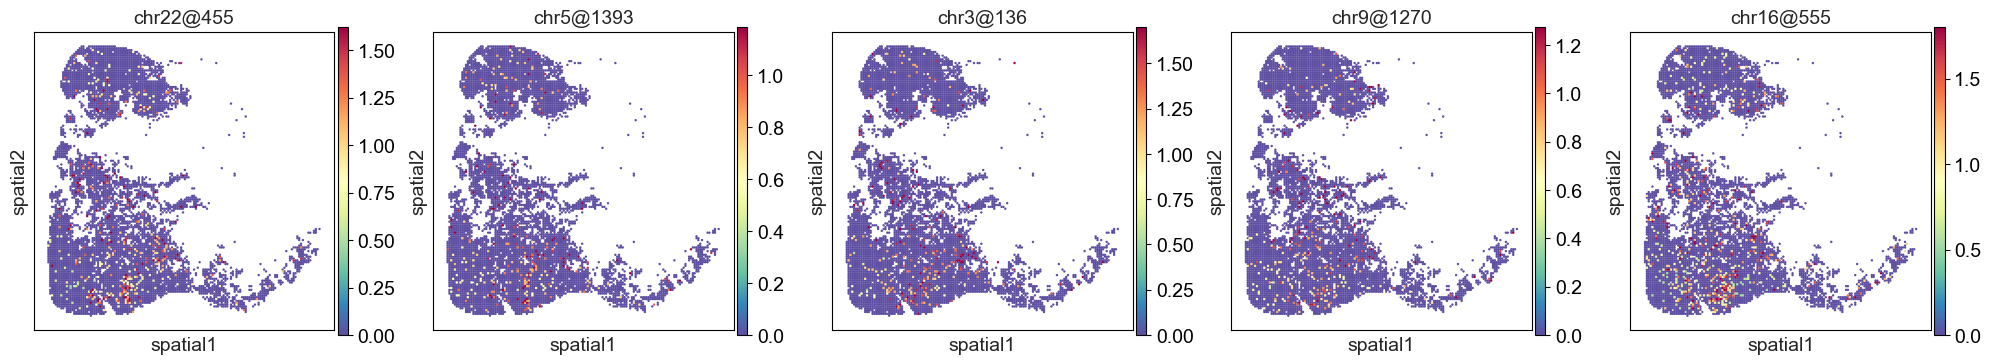

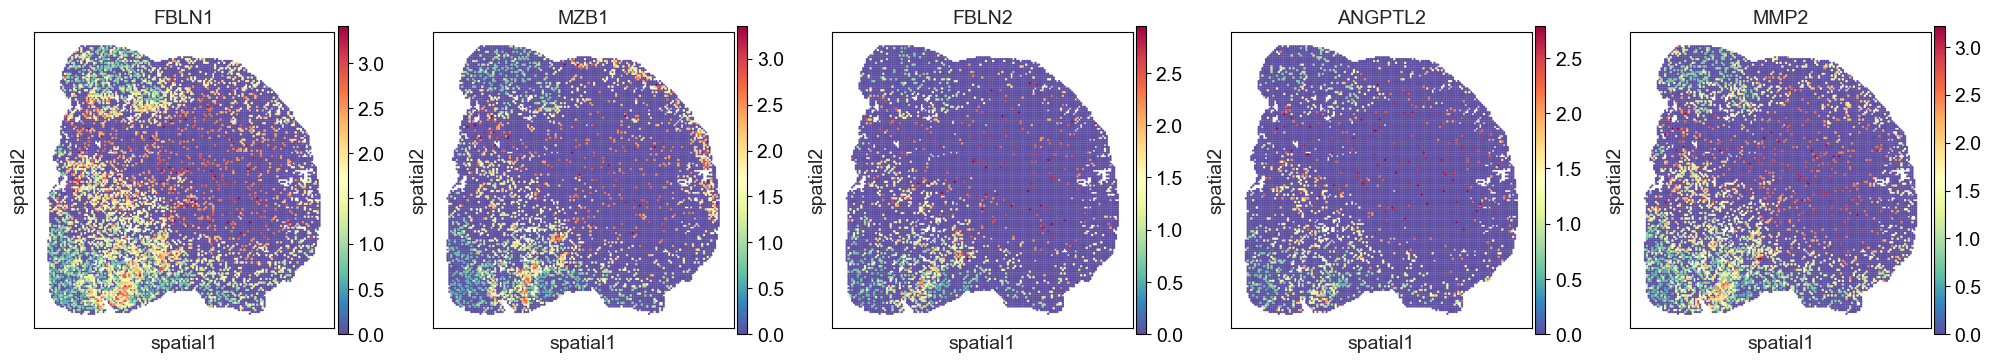

In [64]:
# DUOX2  CCL20     DUOXA1  NOS2 CXCL1

sc.pl.spatial(norm_snv_gene_adata,color = ['chr22@455','chr5@1393','chr3@136','chr9@1270','chr16@555'],spot_size = 130,vmax = 'p99',cmap = 'Spectral_r',ncols = 5,save = 'sg1.crc19..snv.pdf')
sc.pl.spatial(rna,color = ['FBLN1','MZB1','FBLN2','ANGPTL2','MMP2'],spot_size = 130,vmax = 'p99.9',cmap = 'Spectral_r',ncols = 5,save = 'sg1.crc19.rna.pdf')